In [3]:
# Load example subjects

import pickle
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

fc = []
age = []
sex = []
race = []
sz = []

for sub in demo['Age_cal']:
    try:
        a = demo['Age_cal'][sub]
        s = demo['sex'][sub] == 's1.0'
        r = demo['Race'][sub]
        if r not in ['AA', 'CA']:
            continue
        r = r == 'AA'
        z = demo['DXGROUP_1'][sub] != 'NC'
        fc.append(np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')) 
    except:
        continue
    age.append(a)
    sex.append(s)
    race.append(r)
    sz.append(z)
    
fc = np.stack(fc)
age = np.array(age)
sex = np.array(sex)
race = np.array(race)
sz = np.array(sz)

print(fc.shape, age.shape)

(1165, 34716) (1165,)


In [118]:
'''
BSNIP dataset: For SZ+SAD+BP patients
We find here that predicting age within race/sex groups doesn't improve upon predicting in mixed groups

Never mind, there seems to be a small positive effect to segregating for prediction
'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

sel = (sex == 1) & (race == 1) & (sz == 1)
sel = np.ones(fc.shape[0]).astype('bool')
# print(np.std(age[sel]))
# raise 'bad'

errs = []

for i in range(30):
    xtr, xt, ytr, yt = train_test_split(fc[sel], age[sel], train_size=80)
    
    reg = Ridge(alpha=1).fit(xtr, ytr)
    yhat = reg.predict(xt)
    rmse = np.mean((yhat-yt)**2)**0.5
    print(rmse)
    errs.append(rmse)
    
print(np.mean(errs), np.std(errs))

12.506725128359431
12.674056345289385
12.506085039367886
12.449571721736081
12.158601250367926
12.998184859820634
12.441559003816394
12.61264706207103
12.624809843734216
12.801358608973475
12.59736213141246
12.354870828921433
12.796240716608633
12.50427534763276
12.339416243780924
12.786896891876383
12.747824232751185
12.407882980044958
12.703375966435816
12.48442813722253
12.688939863974536
12.717059843403362
12.564715368328743
12.935936936798981
12.520790358507254
12.929008755868786
12.498973582318815
12.966784955630494
12.735982119840672
12.583167536167435
12.621251055368754 0.19655752994926565


In [385]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class RidgeLow(nn.Module):
    def __init__(self):
        super(RidgeLow, self).__init__()
        self.A = nn.Parameter(0.01*torch.randn(264,60).float().cuda())
        self.b = nn.Parameter(0.01*torch.randn(264,60).float().cuda())
        self.i, self.j = np.triu_indices(264,1)
        
    def gen(self):
        A = self.A@self.A.T
        b = self.b@self.b.T
        return A[self.i,self.j], b[self.i,self.j]
        
    def forward(self, x):
        A,b = self.gen()
        y = torch.einsum('nf,f->n',x-b.unsqueeze(0),A)
        return y

nepochs = 1000
pperiod = 50

# sel = (sex == 0) & (race == 1) &  (sz == 1)
sel = np.ones(fc.shape[0]).astype('bool')

xtr, xt, ytr, yt = [torch.from_numpy(x).float().cuda()
                    for x in train_test_split(fc[sel], age[sel], train_size=80)]

mu = torch.mean(ytr)
ytr = ytr - mu
yt = yt - mu

rl = RidgeLow()
optim = torch.optim.Adam(rl.parameters(), lr=1e-4, weight_decay=1e-4)
prev = 0
counter = 0

for e in range(nepochs):
    optim.zero_grad()
    yhat = rl(xtr)
    loss = torch.mean((ytr-yhat)**2)**0.5
    with torch.no_grad():
        yhat = rl(xt)
        vloss = torch.mean((yt-yhat)**2)**0.5
        vloss = float(vloss)
        if vloss > prev:
            counter += 1
        else:
            counter = 0
        if counter > 5 and e > 50:
            break
        prev = vloss
    pen = torch.mean(torch.abs(rl.A+rl.b))
    (loss+pen).backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)} {float(pen)}')
        
yhat = rl(xt)

with torch.no_grad():
    rmse = torch.mean((yt-yhat)**2)**0.5
    print(rmse)
    print(torch.mean(yt**2)**0.5)

0 12.899469375610352 0.011291845701634884
50 12.5897216796875 0.008114722557365894
100 12.046183586120605 0.007194128353148699
150 10.67581558227539 0.009580649435520172
tensor(13.6814, device='cuda:0')
tensor(14.0250, device='cuda:0')


In [268]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


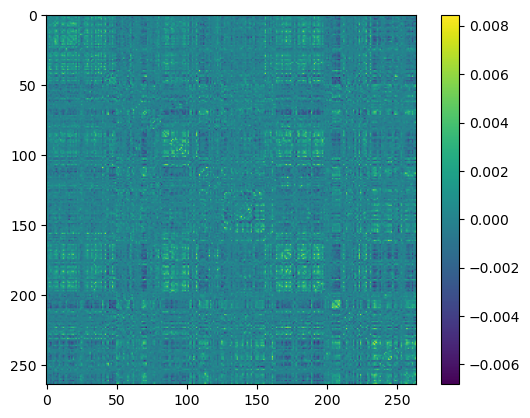

In [369]:
import matplotlib.pyplot as plt

A, b = [x.squeeze().detach().cpu().numpy() for x in rl.gen()]

plt.imshow(remap(vec2mat(A*(fc[8]-b))))
plt.colorbar()
plt.show()